# Промежуточная аттестация по сетям искусcтвенных нейронов.

## Задание

**Ваша задача - создать классификатор изображений с помощью Keras и сверточных нейронных сетей для набора данных Fashion MNIST. Этот набор данных включает 10 меток с разными типами одежды с изображениями 28 на 28 _ в оттенках серого _. Имеется обучающий набор из 60 000 изображений и 10 000 тестовых изображений.**

Описание классов

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot


## Данные

**Загружаем данные**


In [4]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

## Визаулизация датасета

**Используйте matplotlib чтобы показать пример картинки.**


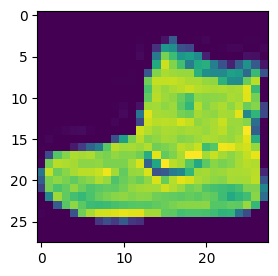

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
plt.imshow(x_train[0])
plt.show()

## Предобработка

**Нормализуйте данные X_train и X_test **


255

**Измените форму массивов X_train и X_test так, чтобы они стали 4-мерными**
batch_size x channels x H x W


**Преобразуйте y_train и y_test в one_hot представления **


## Создайте модель

**Примерная структура модели. При выполнении задания вы можете поэкспериментировать со слоями**

- Сверточный слой, 32 фильтра, размер ядра=(4,4)
- Пулинг с pool_size = (2,2)

- Выпрямляющий слой (Flatten)
- Полносвязный слой (например 128 нейронов), RELU

- Выходной полносвязный слой с 10 нейронами с softmax

**При компиляции укажите loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']**


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
_________________________________________________________________


### Тренировка модели

**Тренируем модель на x_train. Число эпох выберите самостоятельно**


Epoch 1/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.1802 - acc: 0.9365
Epoch 2/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.1679 - acc: 0.9395
Epoch 3/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.1579 - acc: 0.9439
Epoch 4/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.1502 - acc: 0.9469
Epoch 5/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.1427 - acc: 0.9496
Epoch 6/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.1397 - acc: 0.9523
Epoch 7/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.1312 - acc: 0.9551
Epoch 8/10
60000/60000 [==============================] - 5s 86us/step - loss: 0.1274 - acc: 0.9559
Epoch 9/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.1238 - acc: 0.9582
Epoch 10/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.1201 - acc: 0.9588

### Оценка модели

**Оцените модель по метрикам accuracy,precision,recall,f1-score на тестовой выборке x_test **


['loss', 'acc']

In [30]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.86      0.85      0.85      1000
          1       0.99      0.97      0.98      1000
          2       0.88      0.83      0.85      1000
          3       0.91      0.91      0.91      1000
          4       0.83      0.88      0.85      1000
          5       0.97      0.98      0.98      1000
          6       0.73      0.76      0.74      1000
          7       0.95      0.97      0.96      1000
          8       0.99      0.97      0.98      1000
          9       0.98      0.94      0.96      1000

avg / total       0.91      0.91      0.91     10000



## Дополнительно

- Отрисуйте фильтры на слое Conv2D, сравните до и после обучения модели
